# Proyek Klasifikasi Gambar: [Animals]
- **Nama:** [Vittorio Fiorentino]
- **Email:** [a541ybm493@devacademy.id]
- **ID Dicoding:** [A541YBM493]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vittoriofiorentino","key":"15a94ea2c5322f4530e8dcb91a8b1d39"}'}

In [3]:
import os
import shutil

# Hapus jika .kaggle bukan folder
#if os.path.exists("/root/.kaggle") and not os.path.isdir("/root/.kaggle"):
#    os.remove("/root/.kaggle")

# Buat folder .kaggle dan pindahkan file
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar bisa diakses
os.chmod("/root/.kaggle/kaggle.json", 600)


In [4]:

# Download dataset Animal Image Classification
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset

# Unzip dataset
!unzip animal-image-classification-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
  0% 0.00/38.4M [00:00<?, ?B/s]
100% 38.4M/38.4M [00:00<00:00, 1.36GB/s]
Archive:  animal-image-classification-dataset.zip
  inflating: Animals/cats/0_0001.jpg  
  inflating: Animals/cats/0_0002.jpg  
  inflating: Animals/cats/0_0003.jpg  
  inflating: Animals/cats/0_0004.jpg  
  inflating: Animals/cats/0_0005.jpg  
  inflating: Animals/cats/0_0006.jpg  
  inflating: Animals/cats/0_0007.jpg  
  inflating: Animals/cats/0_0008.jpg  
  inflating: Animals/cats/0_0009.jpg  
  inflating: Animals/cats/0_0010.jpg  
  inflating: Animals/cats/0_0011.jpg  
  inflating: Animals/cats/0_0012.jpg  
  inflating: Animals/cats/0_0013.jpg  
  inflating: Animals/cats/0_0014.jpg  
  inflating: Animals/cats/0_0015.jpg  
  inflating: Animals/cats/0_0016.jpg  
  inflating: Animals/cats/0_0017.jpg  
  inflating: Animals/cats/0_0018.jpg  
  inflating: Animals/cats/0_0019.jpg  
  inflating: Animals/cats/

### Data Preprocessing

#### Split Dataset

In [5]:
import os
import shutil
import random

original_path = "Animals"
train_path = os.path.join(original_path, "train")
test_path = os.path.join(original_path, "test")

test_ratio = 0.2  # 20% untuk test

# Buat folder train dan test
for split_path in [train_path, test_path]:
    os.makedirs(split_path, exist_ok=True)

# Ambil hanya folder kelas (bukan folder train/test itu sendiri)
class_names = [name for name in os.listdir(original_path)
               if os.path.isdir(os.path.join(original_path, name))
               and name not in ['train', 'test']]

for class_name in class_names:
    class_folder = os.path.join(original_path, class_name)

    images = os.listdir(class_folder)
    random.shuffle(images)

    split_idx = int(len(images) * (1 - test_ratio))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Buat folder kelas di train dan test
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Salin gambar ke masing-masing folder
    for img in train_images:
        src = os.path.join(class_folder, img)
        dst = os.path.join(train_path, class_name, img)
        if os.path.isfile(src):
            shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_folder, img)
        dst = os.path.join(test_path, class_name, img)
        if os.path.isfile(src):
            shutil.copy(src, dst)

print("✅ Dataset berhasil dipisah ke folder train/test.")


✅ Dataset berhasil dipisah ke folder train/test.


###Gabung data ke dalam folder dataset

In [6]:
animals_path = "Animals"
dataset_path = os.path.join(animals_path, "dataset")

# Buat folder dataset kalau belum ada
os.makedirs(dataset_path, exist_ok=True)

# Folder yang mau di-skip
skip_folders = ['train', 'test', 'dataset']

# Pindahkan folder kelas ke dalam dataset/
for item in os.listdir(animals_path):
    item_path = os.path.join(animals_path, item)
    if os.path.isdir(item_path) and item not in skip_folders:
        target_path = os.path.join(dataset_path, item)
        shutil.move(item_path, target_path)
        print(f"✅ Pindah {item}/ ke dataset/")

print("📦 Semua folder kelas sudah dipindah ke Animals/dataset/. Folder Animals sekarang bersih!")


✅ Pindah dogs/ ke dataset/
✅ Pindah snakes/ ke dataset/
✅ Pindah cats/ ke dataset/
📦 Semua folder kelas sudah dipindah ke Animals/dataset/. Folder Animals sekarang bersih!


###Melihat jumlah gambar pada setiap kelas

In [7]:
path = "Animals/dataset"
for class_name in os.listdir(path):
    class_folder = os.path.join(path, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {num_images} gambar")

dogs: 1000 gambar
snakes: 1000 gambar
cats: 1000 gambar


### Plot Gambar Untuk Semua Kelas

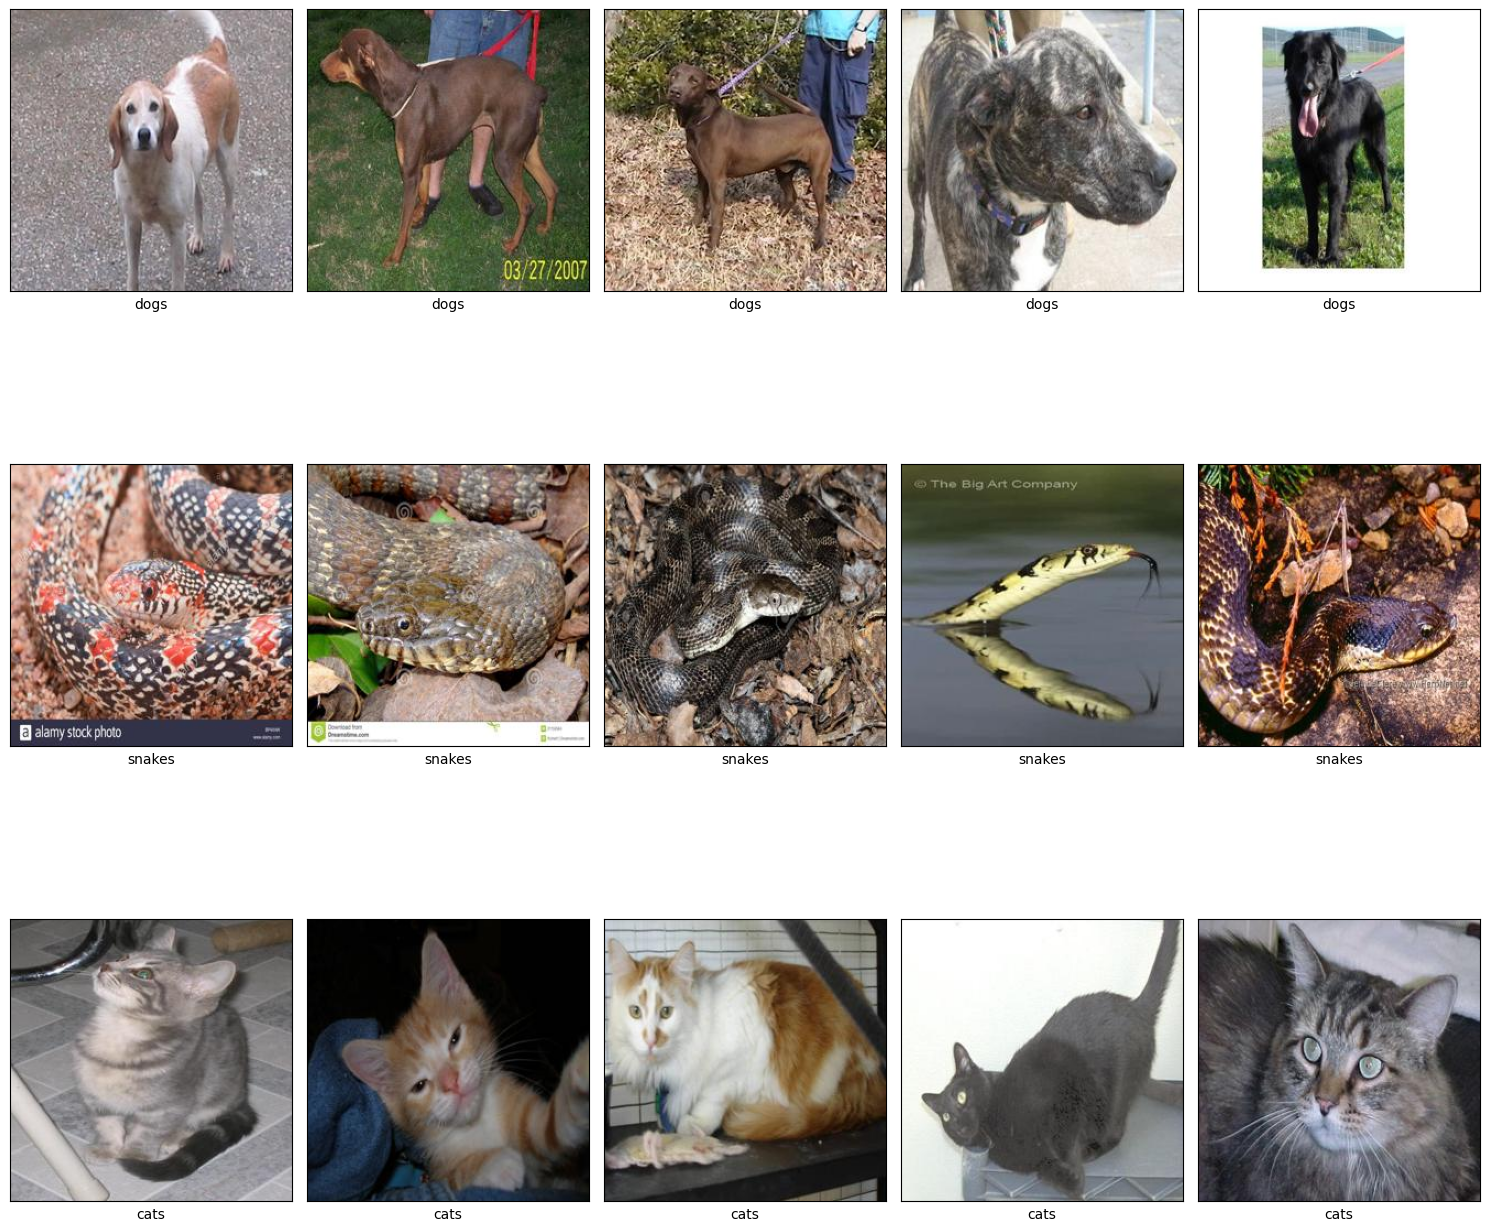

In [8]:

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_images = {}

# Tentukan path sumber
path = "Animals/"
path_sub = os.path.join(path, "dataset")

for i in os.listdir(path_sub):
    animal_images[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "Animals/dataset/"


# Isi kamus dengan nama kelas dan daftar file gambar
for class_name in os.listdir(path_sub):
    class_folder = os.path.join(path_sub, class_name)
    if os.path.isdir(class_folder):
        animal_images[class_name] = os.listdir(class_folder)

# Menampilkan 5 gambar acak dari setiap kelas
fig, axs = plt.subplots(len(animal_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Untuk gambar hewan, lebih baik pakai RGB
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
#plt.show()


### Plot distribusi gambar di seluruh kelas

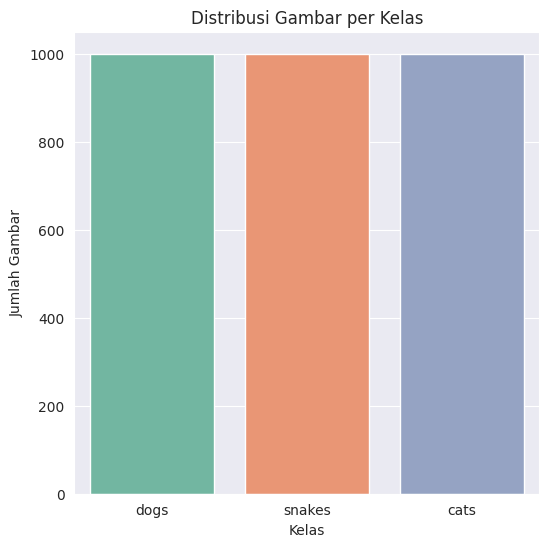

In [9]:
# Path dataset
animal_path = "Animals/dataset/"

# List untuk menyimpan informasi file
file_name = []
labels = []
full_path = []

# Looping ke semua file gambar di folder dataset
for path, subdirs, files in os.walk(animal_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # nama kelas = nama folder
            file_name.append(name)

# Masukkan ke DataFrame
distribution_df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="labels", palette="Set2")

plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

###Data Augmentasi

In [10]:
from skimage import exposure

# Fungsi augmentasi dengan input tensor float32 dan output numpy array
def anticlockwise_rotation(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 3))  # rotasi 90,180,270 derajat ccw
    return img.numpy()

def clockwise_rotation(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    # rotasi searah jarum jam dengan 90,180,270 derajat (3-kali ccw = 1 kali cw)
    img = tf.image.rot90(img, k=4-random.randint(1, 3))
    return img.numpy()

def flip_up_down(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img.numpy()

def add_brightness(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    # pastikan clip nilai supaya gak out of bound
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img.numpy()

def blur_image(img):
    # Untuk blur pakai OpenCV (karena tf.image tidak punya blur)
    img = cv2.resize(img, (224, 224))
    img = cv2.GaussianBlur(img, (3,3), 0)
    # Normalisasi kembali ke 0-1 float
    img = img.astype(np.float32) / 255.0
    return img

def sheared(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img_aug = next(iter(datagen.flow(tf.expand_dims(img.numpy(), 0))))[0]
    return img_aug

def warp_shift(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img_aug = next(iter(datagen.flow(tf.expand_dims(img.numpy(), 0))))[0]
    return img_aug

# Semua fungsi augmentasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Folder dataset original
dataset_path = "Animals/dataset"
# Folder hasil augmentasi
augmented_folder_suffix = "_augmented"

# Buat folder augmented per kelas
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    augmented_path = os.path.join(dataset_path, class_name + augmented_folder_suffix)
    os.makedirs(augmented_path, exist_ok=True)

    print(f"📦 Processing class: {class_name}")

    # Ambil semua gambar kelas tersebut
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    images_to_generate = 200  # jumlah gambar augmentasi yang ingin dibuat per kelas
    i = 1
    while i <= images_to_generate:
        img_path = random.choice(images)
        try:
            original_image = io.imread(img_path)

            # Jika grayscale, convert ke RGB 3 channel
            if original_image.ndim == 2:
                original_image = np.stack([original_image]*3, axis=-1)

            # Normalisasi ke 0-1 float
            if original_image.dtype != np.float32 and original_image.dtype != np.float64:
                original_image = original_image / 255.0
            else:
                if original_image.max() > 1.0 or original_image.min() < 0.0:
                    original_image = exposure.rescale_intensity(original_image, in_range='image', out_range=(0, 1))

            transformed_image = None
            n = 0
            transformation_count = random.randint(1, len(transformations))  # jumlah transformasi acak

            while n < transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](original_image if transformed_image is None else transformed_image)
                n += 1

            # Convert kembali ke uint8 0-255 untuk simpan file
            transformed_image_uint8 = img_as_ubyte(transformed_image)
            save_path = os.path.join(augmented_path, f"augmented_{i:04d}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(transformed_image_uint8, cv2.COLOR_RGB2BGR))
            i += 1
        except Exception as e:
            print(f"⚠️ Gagal proses gambar {img_path}: {e}")

print("✅ Proses augmentasi selesai!")


📦 Processing class: dogs
📦 Processing class: snakes
📦 Processing class: cats
✅ Proses augmentasi selesai!


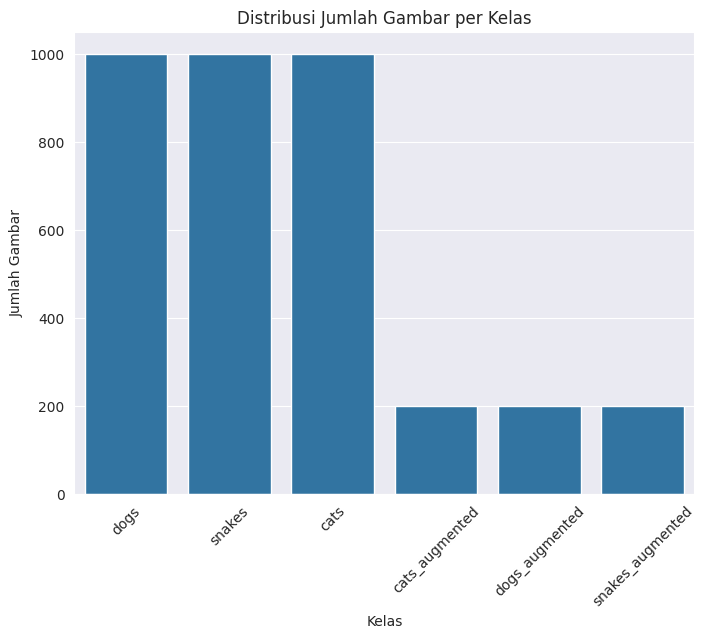

In [11]:

# Definisikan path dataset sesuai folder Animals-mu
animals_path = "Animals/dataset/"

file_names = []
labels = []
full_paths = []

# Loop untuk ambil nama file, path, dan label (nama folder kelas)
for path, subdirs, files in os.walk(animals_path):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_paths.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # ambil nama folder sebagai label
            file_names.append(name)

# Buat DataFrame
distribution_df = pd.DataFrame({
    "path": full_paths,
    "file_name": file_names,
    "labels": labels
})

# Plot distribusi gambar per kelas
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="labels", order=distribution_df['labels'].value_counts().index)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()


### Data Splitting : Train dan Test

In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'Animals/dataset/'

file_name = []
labels = []
full_path = []

# Looping untuk membaca path gambar, labelnya (berdasarkan nama folder), dan nama file
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Label diambil dari nama folder
        file_name.append(name)

# Masukkan ke dataframe agar rapi
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Melihat jumlah data gambar pada masing-masing label
print("Distribusi data:")
print(df.groupby(['labels']).size())

# Variabel yang digunakan pada pemisahan data ini
X = df['path']
y = df['labels']

# Split dataset menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300
)

# Gabungkan hasil split ke dalam dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Print ukuran data hasil split
print('Train size:', len(df_tr))
print('Test size:', len(df_te))


Distribusi data:
labels
cats                1000
cats_augmented       200
dogs                1000
dogs_augmented       200
snakes              1000
snakes_augmented     200
dtype: int64
Train size: 2880
Test size: 720


In [13]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

# Menampilkan jumlah gambar berdasarkan set (train/test) dan label (dogs, cats, snakes)
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Menampilkan 5 sample data secara acak
print(df_all.sample(5))



set    labels          
test   cats                188
       cats_augmented       48
       dogs                212
       dogs_augmented       37
       snakes              189
       snakes_augmented     46
train  cats                812
       cats_augmented      152
       dogs                788
       dogs_augmented      163
       snakes              811
       snakes_augmented    154
dtype: int64 


                                                   path            labels  \
2958                    Animals/dataset/cats/0_0229.jpg              cats   
1449                  Animals/dataset/snakes/2_0633.jpg            snakes   
573                     Animals/dataset/cats/0_0377.jpg              cats   
1407  Animals/dataset/snakes_augmented/augmented_003...  snakes_augmented   
2832                    Animals/dataset/dogs/1_0745.jpg              dogs   

        set  
2958   test  
1449  train  
573   train  
1407  train  
2832  train  


In [14]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Animals/dataset/"

# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


In [15]:

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    # Buat direktori tujuan folder jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Tentukan nama dan lokasi tujuan file
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file jika belum ada di tujuan
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)


0it [00:00, ?it/s]

In [16]:

def merge_augmented(folder_base_path):
    classes = ['cats', 'dogs', 'snakes']  # sesuaikan dengan kelas kamu

    for cls in classes:
        original_folder = os.path.join(folder_base_path, cls)
        augmented_folder = os.path.join(folder_base_path, f"{cls}_augmented")

        if os.path.exists(augmented_folder):
            # Pastikan folder asli ada
            if not os.path.exists(original_folder):
                os.makedirs(original_folder)

            # Pindahkan semua file dari folder augmented ke folder asli
            for filename in os.listdir(augmented_folder):
                src_path = os.path.join(augmented_folder, filename)
                dst_path = os.path.join(original_folder, filename)

                # Jika nama file sudah ada, kamu bisa rename atau overwrite sesuai kebutuhan
                if not os.path.exists(dst_path):
                    shutil.move(src_path, dst_path)
                else:
                    print(f"File {dst_path} sudah ada, dilewati.")

            # Hapus folder augmented setelah pindah
            os.rmdir(augmented_folder)
            print(f"Folder {augmented_folder} sudah dipindahkan dan dihapus.")
        else:
            print(f"Folder {augmented_folder} tidak ditemukan, lanjut ke kelas berikutnya.")

# Contoh untuk train dan test
merge_augmented('Dataset-Final/train')
merge_augmented('Dataset-Final/test')


Folder Dataset-Final/train/cats_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/train/dogs_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/train/snakes_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/test/cats_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/test/dogs_augmented sudah dipindahkan dan dihapus.
Folder Dataset-Final/test/snakes_augmented sudah dipindahkan dan dihapus.


### Image Data Generator

In [17]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Buat path untuk masing-masing kelas
train_dogs = os.path.join(TRAIN_DIR, 'dogs')
train_cats = os.path.join(TRAIN_DIR, 'cats')
train_snakes = os.path.join(TRAIN_DIR, 'snakes')

test_dogs = os.path.join(TEST_DIR, 'dogs')
test_cats = os.path.join(TEST_DIR, 'cats')
test_snakes = os.path.join(TEST_DIR, 'snakes')

# Tampilkan jumlah gambar di setiap kelas pada dataset training dan testing
print("Total number of dog images in training set: ", len(os.listdir(train_dogs)))
print("Total number of cat images in training set: ", len(os.listdir(train_cats)))
print("Total number of snake images in training set: ", len(os.listdir(train_snakes)))

print("Total number of dog images in test set: ", len(os.listdir(test_dogs)))
print("Total number of cat images in test set: ", len(os.listdir(test_cats)))
print("Total number of snake images in test set: ", len(os.listdir(test_snakes)))


Total number of dog images in training set:  951
Total number of cat images in training set:  964
Total number of snake images in training set:  965
Total number of dog images in test set:  249
Total number of cat images in test set:  236
Total number of snake images in test set:  235


In [18]:

# Buat ImageDataGenerator untuk normalisasi dan split validasi dari training set
datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


# Generator untuk test set
test_datagen = ImageDataGenerator(rescale=1/255.0)

# Generator untuk training
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',  # multiclass (3 kelas)
    subset='training',
    shuffle=True
)

# Generator untuk validasi
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',  # multiclass (3 kelas)
    subset='validation',
    shuffle=False
)

# Generator untuk test set
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=1,
    class_mode='categorical',  # multiclass (3 kelas)
    shuffle=False
)


Found 2305 images belonging to 3 classes.
Found 575 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


## Modelling

###Conv2D

In [19]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################

model_6 = Sequential()

# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))


# Flatten layer
model_6.add(Flatten())

# Dense layers
model_6.add(Dense(128, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dropout(0.3))

# Final Dense layer => 3 output neurons untuk 3 kelas + softmax
model_6.add(Dense(3, activation='softmax'))

######################### Compile Model ################################

model_6.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model_6.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,587 (5.35 MB)

 Trainable params: 1,403,395 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [20]:
from sklearn.utils import class_weight
# Ambil label dari generator (berdasarkan urutan kelas dari subfolder)
train_labels = train_generator.classes

# Hitung class weight untuk semua kelas (otomatis mendeteksi jumlah kelas)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Konversi ke dictionary untuk dipakai di model.fit()
class_weights = dict(enumerate(class_weights_array))

%time


earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history_6 = model_6.fit(
    train_generator,
    epochs=40,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[earlystop, checkpoint]
)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4268 - loss: 1.6487

73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - accuracy: 0.4273 - loss: 1.6450 - val_accuracy: 0.3339 - val_loss: 1.6132
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.4856 - loss: 1.1225 - val_accuracy: 0.3339 - val_loss: 1.6320
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.5184 - loss: 1.0291 - val_accuracy: 0.3339 - val_loss: 1.7955
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.5437 - loss: 0.9824 - val_accuracy: 0.3339 - val_loss: 1.8405
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5732 - loss: 0.9146

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.5730 - loss: 0.9147 - val_accuracy: 0.3739 - val_loss: 1.3724
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5635 - loss: 0.8935

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.5633 - loss: 0.8936 - val_accuracy: 0.4522 - val_loss: 1.0728
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5607 - loss: 0.8964

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step - accuracy: 0.5608 - loss: 0.8964 - val_accuracy: 0.5617 - val_loss: 0.8950
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5580 - loss: 0.9033

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.5580 - loss: 0.9031 - val_accuracy: 0.6174 - val_loss: 0.8067
Epoch 9/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5677 - loss: 0.8749

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.5679 - loss: 0.8748 - val_accuracy: 0.5983 - val_loss: 0.7874
Epoch 10/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5867 - loss: 0.8870

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.5867 - loss: 0.8867 - val_accuracy: 0.6643 - val_loss: 0.7473
Epoch 11/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5883 - loss: 0.8671

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.5883 - loss: 0.8669 - val_accuracy: 0.6661 - val_loss: 0.7264
Epoch 12/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5489 - loss: 0.8864

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 239ms/step - accuracy: 0.5493 - loss: 0.8862 - val_accuracy: 0.6435 - val_loss: 0.7235
Epoch 13/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.5962 - loss: 0.8251 - val_accuracy: 0.6487 - val_loss: 0.7275
Epoch 14/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5816 - loss: 0.8596

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.5819 - loss: 0.8593 - val_accuracy: 0.6452 - val_loss: 0.6990
Epoch 15/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.5812 - loss: 0.8451 - val_accuracy: 0.6678 - val_loss: 0.7195
Epoch 16/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.6168 - loss: 0.7888 - val_accuracy: 0.6696 - val_loss: 0.6999
Epoch 17/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6244 - loss: 0.7891

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6242 - loss: 0.7896 - val_accuracy: 0.6852 - val_loss: 0.6770
Epoch 18/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.6157 - loss: 0.7684 - val_accuracy: 0.6817 - val_loss: 0.6912
Epoch 19/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.6140 - loss: 0.7903 - val_accuracy: 0.6452 - val_loss: 0.7183
Epoch 20/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6169 - loss: 0.7854

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.6168 - loss: 0.7856 - val_accuracy: 0.6939 - val_loss: 0.6766
Epoch 21/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.6117 - loss: 0.7927 - val_accuracy: 0.6800 - val_loss: 0.6846
Epoch 22/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.6460 - loss: 0.7444 - val_accuracy: 0.6522 - val_loss: 0.7150
Epoch 23/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.6456 - loss: 0.7715 - val_accuracy: 0.6609 - val_loss: 0.7179
Epoch 24/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.6419 - loss: 0.7511 - val_accuracy: 0.6974 - val_loss: 0.6925
Epoch 25/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.6275 - loss: 0.7665 - val_accuracy: 0.6557 - val_loss: 0.7196
Epoch 26/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6396 - loss: 0.7803

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.6396 - loss: 0.7802 - val_accuracy: 0.6904 - val_loss: 0.6535
Epoch 27/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.6483 - loss: 0.7286 - val_accuracy: 0.6957 - val_loss: 0.7096
Epoch 28/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6532 - loss: 0.7218

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6532 - loss: 0.7217 - val_accuracy: 0.6904 - val_loss: 0.6525
Epoch 29/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.6697 - loss: 0.6868 - val_accuracy: 0.6296 - val_loss: 0.8452
Epoch 30/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6555 - loss: 0.6783

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.6554 - loss: 0.6789 - val_accuracy: 0.7078 - val_loss: 0.6483
Epoch 31/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6272 - loss: 0.7758 - val_accuracy: 0.6713 - val_loss: 0.6780
Epoch 32/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.6437 - loss: 0.7474 - val_accuracy: 0.6783 - val_loss: 0.6610
Epoch 33/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.6397 - loss: 0.7246 - val_accuracy: 0.6887 - val_loss: 0.6672
Epoch 34/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.6803 - loss: 0.6889 - val_accuracy: 0.7043 - val_loss: 0.6579
Epoch 35/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6742 - loss: 0.7197

73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.6740 - loss: 0.7197 - val_accuracy: 0.7165 - val_loss: 0.6327
Epoch 36/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6775 - loss: 0.6951

73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6774 - loss: 0.6951 - val_accuracy: 0.7165 - val_loss: 0.6283
Epoch 37/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.6651 - loss: 0.7147 - val_accuracy: 0.7200 - val_loss: 0.6499
Epoch 38/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6872 - loss: 0.6544 - val_accuracy: 0.7026 - val_loss: 0.6444
Epoch 39/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6906 - loss: 0.6578 - val_accuracy: 0.7113 - val_loss: 0.6581
Epoch 40/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.6574 - loss: 0.6931 - val_accuracy: 0.6957 - val_loss: 0.6488


Dikarenakan uji coba modelling Conv2D, cukup rendah dengan nilai accuracy sekitar 0.6842, maka kita akan menggunakan transfer learning untuk meningkatkan nilai accuracy.

###Transfer Learning

In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

tf.keras.backend.clear_session()

# Tambahkan Input layer secara eksplisit di luar base_model
model_1 = Sequential([
    Input(shape=(150, 150, 3)),  # <-- ini penting
    MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

<ipython-input-37-61aabd339191>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3)),


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,096,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,354,499 (24.24 MB)

 Trainable params: 6,320,387 (24.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [38]:
from sklearn.utils import class_weight
# Ambil label dari generator (berdasarkan urutan kelas dari subfolder)
train_labels = train_generator.classes

# Hitung class weight untuk semua kelas (otomatis mendeteksi jumlah kelas)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Konversi ke dictionary untuk dipakai di model.fit()
class_weights = dict(enumerate(class_weights_array))

%time


earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history_1 = model_1.fit(
    train_generator,
    epochs=40,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[earlystop, checkpoint]
)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6891 - loss: 0.9438

73/73 ━━━━━━━━━━━━━━━━━━━━ 86s 564ms/step - accuracy: 0.6903 - loss: 0.9390 - val_accuracy: 0.9078 - val_loss: 0.3643
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8769 - loss: 0.3137

73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.8770 - loss: 0.3133 - val_accuracy: 0.9496 - val_loss: 0.2168
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.8971 - loss: 0.2269 - val_accuracy: 0.9426 - val_loss: 0.2519
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.9031 - loss: 0.2321 - val_accuracy: 0.9026 - val_loss: 0.4766
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9194 - loss: 0.1755 - val_accuracy: 0.9374 - val_loss: 0.3015
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 0.9117 - loss: 0.1902 - val_accuracy: 0.9357 - val_loss: 0.3166
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.9140 - loss: 0.1842 - val_accuracy: 0.9426 - val_loss: 0.2959
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.9095 - loss: 0.1867 - val_accuracy: 0.9513 - val_loss: 0.2307
Epoch 9/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9074 - loss: 0.1892

73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9074 - loss: 0.1893 - val_accuracy: 0.9652 - val_loss: 0.1671
Epoch 10/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.9178 - loss: 0.1763 - val_accuracy: 0.9530 - val_loss: 0.2927
Epoch 11/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.9097 - loss: 0.1974 - val_accuracy: 0.9496 - val_loss: 0.2918
Epoch 12/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9040 - loss: 0.1937 - val_accuracy: 0.9583 - val_loss: 0.2029
Epoch 13/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 0.9161 - loss: 0.1668 - val_accuracy: 0.9617 - val_loss: 0.1735
Epoch 14/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9118 - loss: 0.1653

73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9120 - loss: 0.1653 - val_accuracy: 0.9739 - val_loss: 0.1616
Epoch 15/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9318 - loss: 0.1408 - val_accuracy: 0.9635 - val_loss: 0.2119
Epoch 16/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9226 - loss: 0.1610 - val_accuracy: 0.9600 - val_loss: 0.1933
Epoch 17/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.9291 - loss: 0.1450 - val_accuracy: 0.9461 - val_loss: 0.3609
Epoch 18/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.9096 - loss: 0.1771 - val_accuracy: 0.9426 - val_loss: 0.3009
Epoch 19/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9179 - loss: 0.1717 - val_accuracy: 0.9530 - val_loss: 0.2207
Epoch 20/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 259ms/step - accuracy: 0.9129 - loss: 0.1886 - val_accuracy: 0.9652 - val_loss: 0.1723
Epoch 21/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.9081 - loss: 0.1717 - val_accuracy

73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.9272 - loss: 0.1565 - val_accuracy: 0.9774 - val_loss: 0.1592
Epoch 26/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.9286 - loss: 0.1452 - val_accuracy: 0.9583 - val_loss: 0.2269
Epoch 27/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9139 - loss: 0.1924 - val_accuracy: 0.9478 - val_loss: 0.2901
Epoch 28/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9238 - loss: 0.1640 - val_accuracy: 0.9513 - val_loss: 0.3197
Epoch 29/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.9267 - loss: 0.1505 - val_accuracy: 0.9530 - val_loss: 0.2834
Epoch 30/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9340 - loss: 0.1434 - val_accuracy: 0.9652 - val_loss: 0.2103
Epoch 31/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9262 - loss: 0.1476 - val_accuracy: 0.9635 - val_loss: 0.2361
Epoch 32/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9289 - loss: 0.1422 - val_accuracy

## Evaluasi dan Visualisasi

###Conv2D

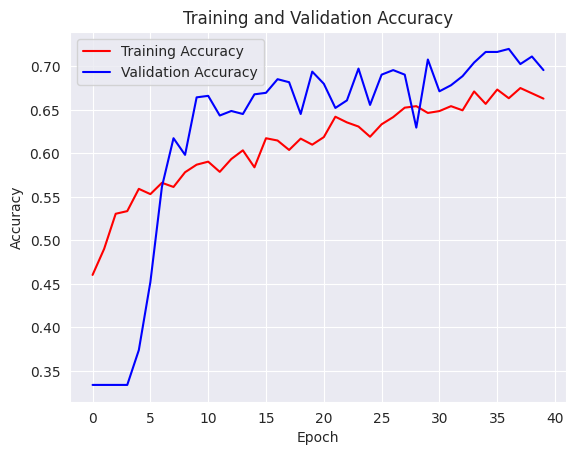

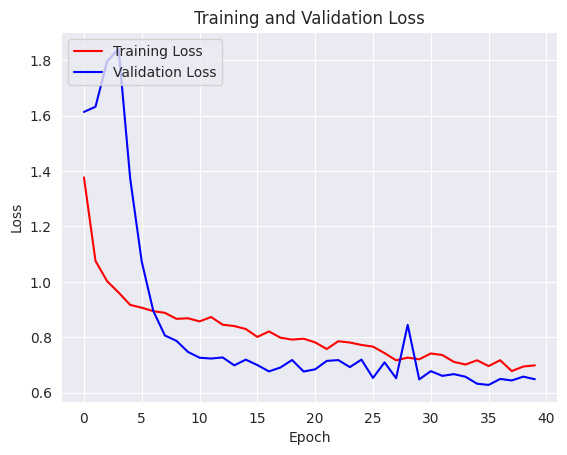

In [23]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


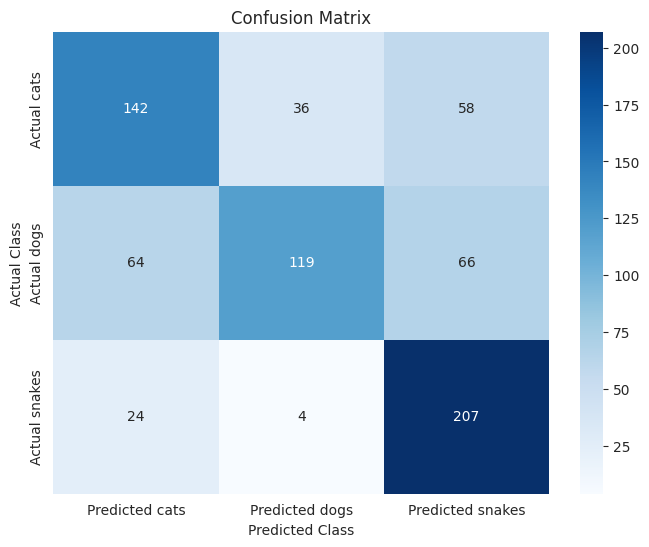


Classification Report:

              precision    recall  f1-score   support

        cats     0.6174    0.6017    0.6094       236
        dogs     0.7484    0.4779    0.5833       249
      snakes     0.6254    0.8809    0.7314       235

    accuracy                         0.6500       720
   macro avg     0.6637    0.6535    0.6414       720
weighted avg     0.6653    0.6500    0.6402       720



In [24]:


# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi menggunakan model
preds_6 = model_6.predict(test_generator, verbose=0)

# Ambil index kelas dengan probabilitas tertinggi (argmax)
y_pred = np.argmax(preds_6, axis=1)
y_true = test_generator.classes

# Buat label nama kelas dari generator
labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual {label}" for label in labels],
                         columns=[f"Predicted {label}" for label in labels])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))


###Transfer Learning

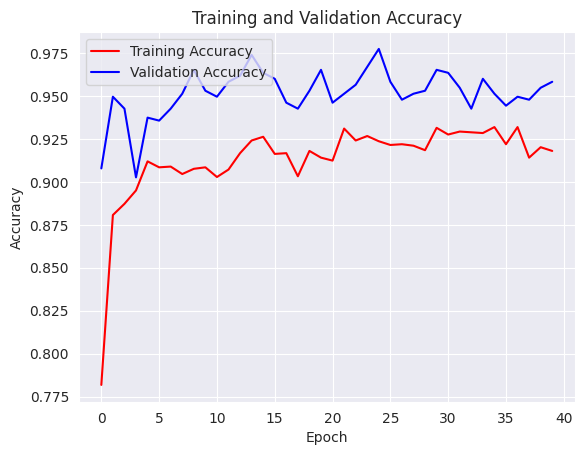

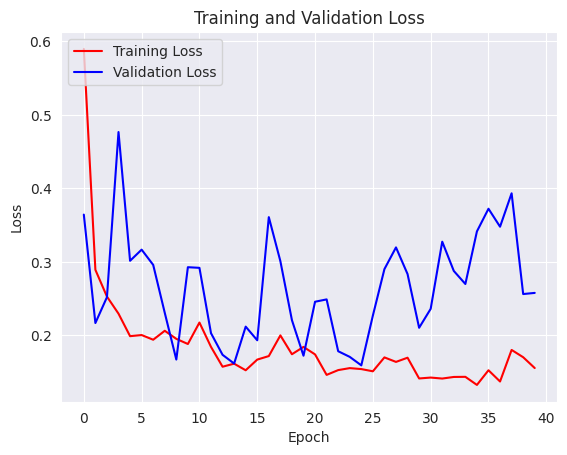

In [39]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


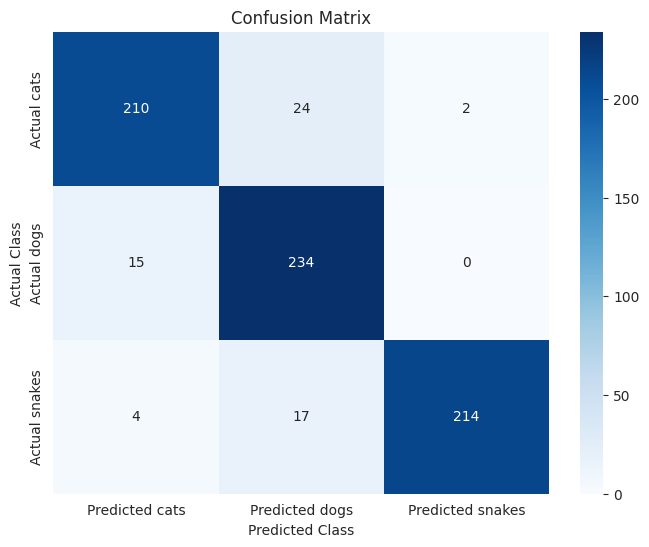


Classification Report:

              precision    recall  f1-score   support

        cats     0.9170    0.8898    0.9032       236
        dogs     0.8509    0.9398    0.8931       249
      snakes     0.9907    0.9106    0.9490       235

    accuracy                         0.9139       720
   macro avg     0.9196    0.9134    0.9151       720
weighted avg     0.9182    0.9139    0.9147       720



In [40]:


# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi menggunakan model
preds_1 = model_1.predict(test_generator, verbose=0)

# Ambil index kelas dengan probabilitas tertinggi (argmax)
y_pred = np.argmax(preds_1, axis=1)
y_true = test_generator.classes

# Buat label nama kelas dari generator
labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual {label}" for label in labels],
                         columns=[f"Predicted {label}" for label in labels])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))


## Konversi Model

### Format saveModel

In [41]:
save_path = os.path.join("models/rps_model/1/")
tf.saved_model.save(model_1, save_path)


###Format TFJS

In [47]:
model_1.save("model.h5")

In [43]:
!pip install tensorflowjs

In [46]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-06-02 16:53:17.953841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748883197.987895   16428 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748883197.999212   16428 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


###Format TF-Lite

In [31]:
export_dir = 'saved_model/'
tf.saved_model.save(model_1, export_dir)


In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


In [33]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


204136

Download Folder Model

In [35]:
!zip -r koko_model_all.zip models saved_model tfjs_model
from google.colab import files
files.download('koko_model_all.zip')


  adding: models/ (stored 0%)
  adding: models/rps_model/ (stored 0%)
  adding: models/rps_model/1/ (stored 0%)
  adding: models/rps_model/1/assets/ (stored 0%)
  adding: models/rps_model/1/fingerprint.pb (stored 0%)
  adding: models/rps_model/1/saved_model.pb (deflated 92%)
  adding: models/rps_model/1/variables/ (stored 0%)
  adding: models/rps_model/1/variables/variables.index (deflated 78%)
  adding: models/rps_model/1/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 78%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of7.bin (deflated 8%)
  adding: tfjs_model/group1-shard5of7.bin (deflated 7%)
  adding: t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

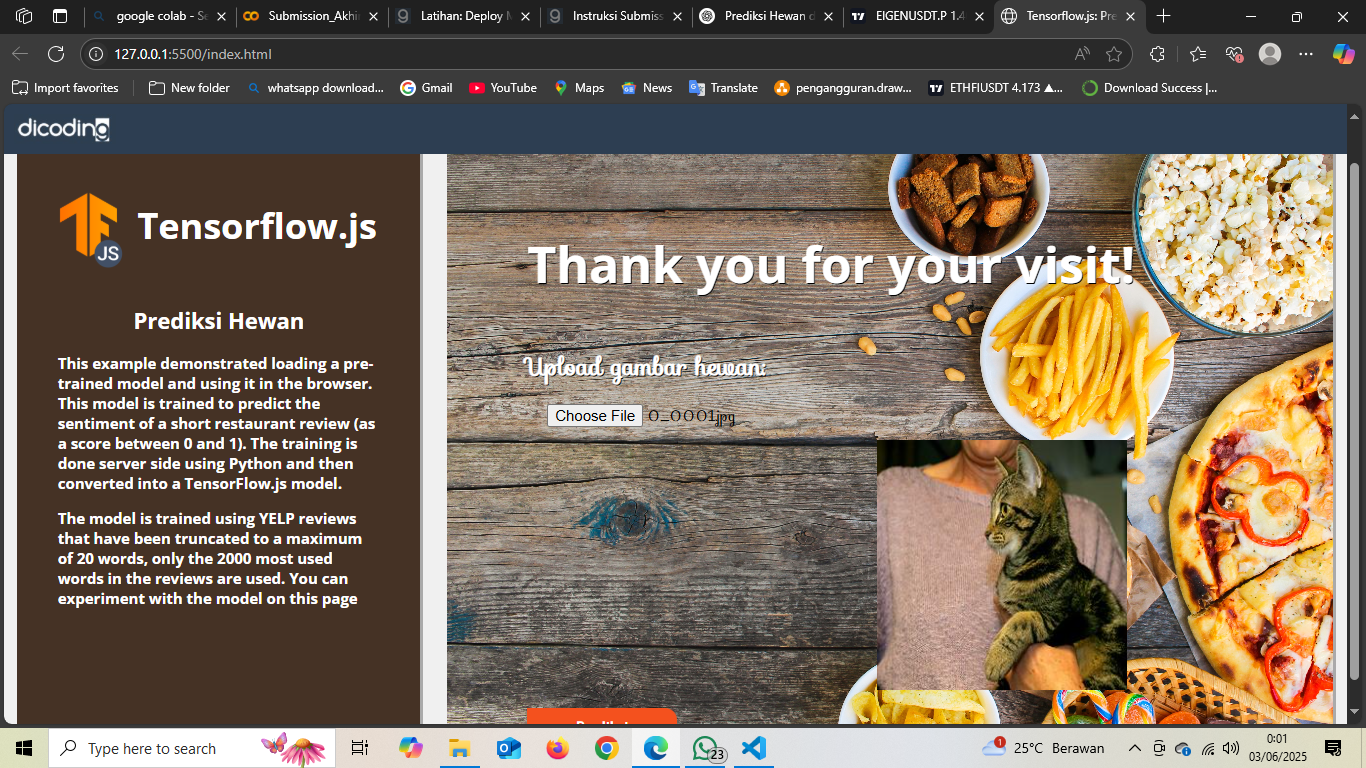